### NLP Project - Resume Classification

####  EDA & Visualization

##### Install Required Library

In [2]:
#!pip install docx2txt

In [4]:
#!pip install TextBlob

In [5]:
# importing required modules
import pandas as pd
import numpy as np
import re
import spacy
from spacy.matcher import Matcher
from os import listdir
from os.path import isfile, join

#Data Prepartion
import docx2txt
import io
import string

#NLP Feature Extraction
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

##### Data Preparation

In [6]:
#Google Drive Mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Inference: 
I Have Used Google Colob, Upload the "Resumes_Dataset" Folder onto your Google Drive Which you get From the conversion file.

In [7]:
#Converting All the Resumes into a Single Corpus
text = []
mypath = '/content/drive/MyDrive/Resumes_Dataset'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
def extract_text_from_doc(doc_path):
    temp = docx2txt.process(doc_path)
    text = [line.replace('\t', ' ') for line in temp.split('\n') if line]
    return ' '.join(text)

# Calling function
for i in range(len(onlyfiles)):
    text.append(extract_text_from_doc(f'/content/drive/MyDrive/Resumes_Dataset/{onlyfiles[i]}'))

In [8]:
print("Total Resumes:",len(onlyfiles))

Total Resumes: 79


In [9]:
#Resumes Converted into a list of Text
print("Total_Resumes text List Elememt:",len(text))

Total_Resumes text List Elememt: 79


Inference: Here we Get Each Resume as a Text,as a Different Element in the List

In [10]:
#First Resume as Text
text[0][:500] #Getting only 500 words

'Kotani Durga Prasad Objective: Aspirant for a position in an organization where I can contribute my skills for organization’s success and synchronize with new technologies while being resourceful, innovative and flexible. Professional Summary:  3.1 years of experience as a Software Engineer.  Highly creative web designer and front end developer with experience of working on a diverse range of projects from small business websites to large scale websites with a global user base.  Excellent knowle'

In [11]:
#First Resume as Text
text[0][-500:] #Getting last 500 words

'ility according to the device capabilities. Roles and Responsibilities:  HTML Development  Developing Drop down menus using jQuery  Developing dynamic background using JQuery mobile. UI Technologies Used:  HTML5, CSS3, JQuery. Personal Details:  Nationality: Indian  Sex: Male  Marital Status: Unmarried  Languages Known : English, Hindi, Telugu Declaration: I hereby declare that the information furnished above is true to the best of my knowledge and belief. Date:  Place: Vijayawada K.Durga Prasad'

#### Note:
In These Resumes there are no Entities like email_id,phone_no, linkedin_id etc So will Add Fake information For These,As we Would Only Require the Pattern of the Entities to be Learnt By the Model for Parsing

In [12]:
# Adding fake email ids, phone numbers and links
f_id = 'abc@xyz.com'
f_no = '+911234567890'
f_linkedin = 'https://www.linkedin.com/fake'
f_github = 'https://www.github.com/fake'
f_str = f_id+' '+f_no+' '+ f_linkedin+ ' '+f_github

new_text = []
for i in text:
    new_text.append(i+' '+f_str)

In [13]:
#Checking if the Entities are Appended in the text
new_text[0][-500:]

'pment  Developing Drop down menus using jQuery  Developing dynamic background using JQuery mobile. UI Technologies Used:  HTML5, CSS3, JQuery. Personal Details:  Nationality: Indian  Sex: Male  Marital Status: Unmarried  Languages Known : English, Hindi, Telugu Declaration: I hereby declare that the information furnished above is true to the best of my knowledge and belief. Date:  Place: Vijayawada K.Durga Prasad abc@xyz.com +911234567890 https://www.linkedin.com/fake https://www.github.com/fake'

Inference: Here we Can See At the Last,the Entities are Added

In [14]:
# Storing in a DataFrame 
df = pd.DataFrame(new_text, columns=['Text'])
df.head()

,Text
0,Kotani Durga Prasad Objective: Aspirant for a ...
1,Ui-Developer/ React JS Developer NAME: KRISHN...
2,MAREEDU LOKESH BABU PROFESSIONAL OVERVIEW ...
3,KAMALAKAR REDDY. A Linked In: https://www.lin...
4,Thirupathamma Balla SUMMARY: 2.8 year of IT ex...


In [15]:
#Checking the Shape of the Dataframe
df.shape

(79, 1)

Inference: We Have 79 Rows Which is Equal to Our Number of Resumes 

#### Data Cleaning

In [16]:
#Initializing the Stemming Process
stemmer = PorterStemmer()
lemmetizer = WordNetLemmatizer()

#Setting Up the Stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = stopwords.words('english')

#Checking the Punctuation
string.punctuation

#Adding Our Own Stopwords
more_stop_words = ['\x0c','"','-','_','.']
stop_words.extend(more_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [17]:
#clean_data() takes sentence separated string input and cleans the data i.e. removing stopwords and punctuation and returning lemmetized string output
def clean_data(text):
    re.sub(r'[\d]','',text)
    re.sub(r'[^a-zA-Z]','',text)
    re.sub('\s+',' ',text)
    text_clean = []
    text_tokens = word_tokenize(text)
    #text_tokens = tokenizer.tokenize(text)    
    for word in text_tokens:
        if (word not in stop_words and # remove stopwords
            word not in string.punctuation): # remove punctuation
            stem_word = lemmetizer.lemmatize(word) # stemming word
            text_clean.append(stem_word)
    
    list_to_str = ' '.join([str(ele) for ele in text_clean])
    return list_to_str.lower()

In [18]:
#call_to_clean() takes full text as input, breaks them into sentences and calls the clean_data() with the separated sentences as arguments
clean_text = []
def call_to_clean(text):
    sentences = re.split(r'\n+',text)
    sentence_df = pd.DataFrame(sentences, columns = ['Text'])
    sentence_df['Text'] = sentence_df['Text'].apply(clean_data)
    clean_text.append(' '.join(sentence_df['Text']))

In [19]:
#Calling the Function to Get Clean Text
for i in range(len(df)):
    call_to_clean(df['Text'].loc[i])

In [20]:
#Checking the Clean Text
clean_text[0][:500]

'kotani durga prasad objective aspirant position organization i contribute skill organization ’ success synchronize new technology resourceful innovative flexible professional summary 3.1 year experience software engineer highly creative web designer front end developer experience working diverse range project small business website large scale website global user base excellent knowledge html html5 css3 bootstrap framework strong hand experience hand coding web technology good knowledge designin'

#### Cleaned Data

In [21]:
#Adding A Column of Clean Data as "Clean Text"
df['Clean Text'] = clean_text
df.head()

,Text,Clean Text
0,Kotani Durga Prasad Objective: Aspirant for a ...,kotani durga prasad objective aspirant positio...
1,Ui-Developer/ React JS Developer NAME: KRISHN...,ui-developer/ react js developer name krishna ...
2,MAREEDU LOKESH BABU PROFESSIONAL OVERVIEW ...,mareedu lokesh babu professional overview arou...
3,KAMALAKAR REDDY. A Linked In: https://www.lin...,kamalakar reddy a linked in http //www.linkedi...
4,Thirupathamma Balla SUMMARY: 2.8 year of IT ex...,thirupathamma balla summary 2.8 year it experi...


### Visualization

##### WordCloud 
For Commonly used words in the Resumes

In [22]:
#Againg Creating a Single List of Text for all Resumes
sentences = []
for i in range(len(df)):
    sentences.append(sent_tokenize(df['Text'][i]))

sentences = np.array(str(sentences)).reshape(-1,1)
#Creating a Dataframe of the List Created
sentence_df = pd.DataFrame(sentences, columns = ['Text'])

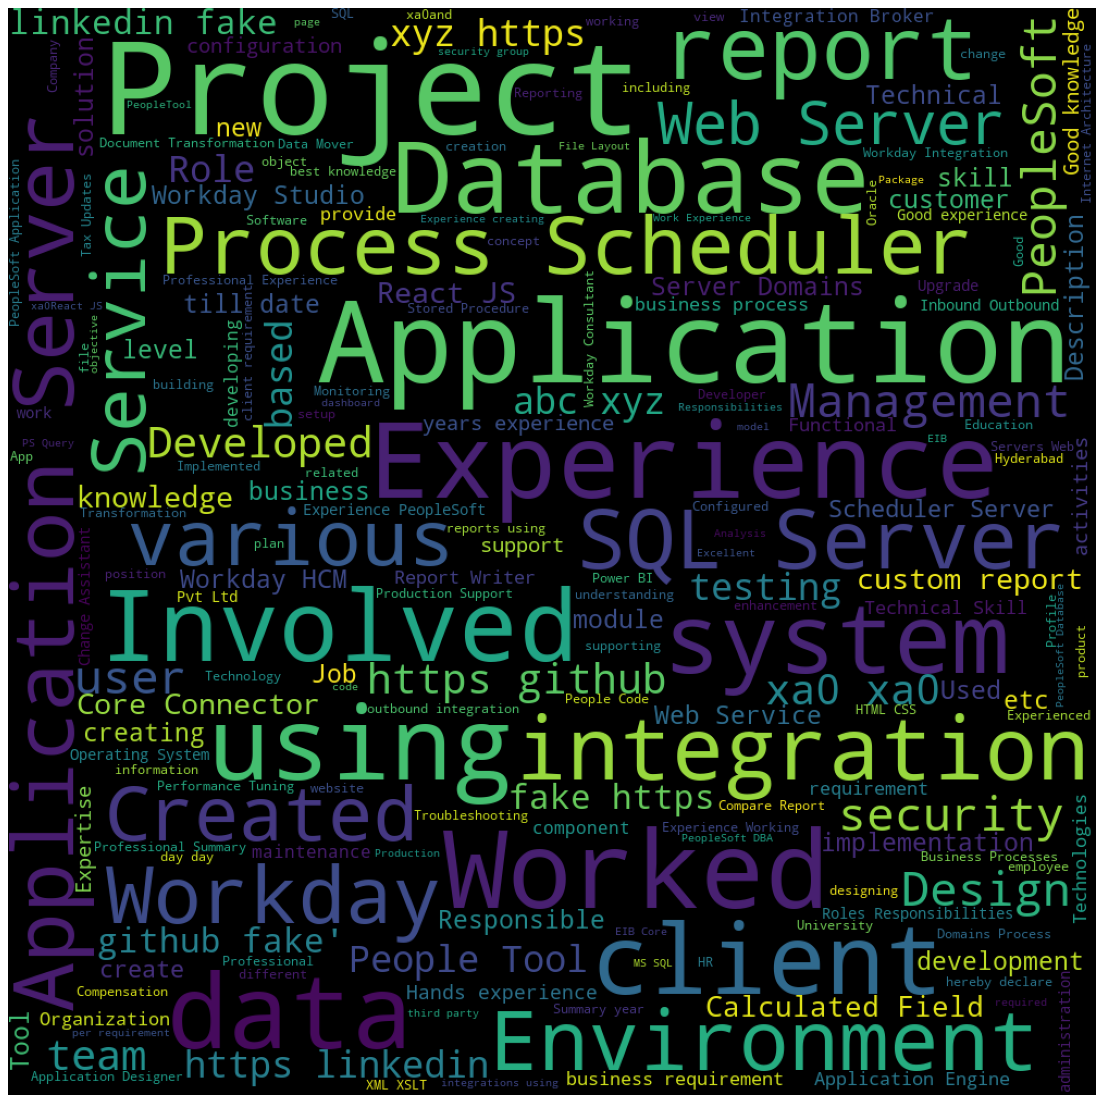

In [23]:
# Generating a wordcloud
allwords = " ".join([txt for txt in sentence_df["Text"]])
wordCloud = WordCloud(width = 1000, height = 1000, random_state = 42, max_font_size = 119).generate(allwords)
plt.figure(figsize=(18, 18), dpi=80)
plt.imshow(wordCloud)
plt.axis('off')
plt.show()

Inference : Words like Experience, SQL Server, Environment,data, Github are used very regularly

#### Plotting n-grams

In [24]:
#Creating Required Columns For Analysis
df['polarity'] = df['Clean Text'].map(lambda text: TextBlob(text).sentiment.polarity) #Gives a Sentiment Score
df['Clean_len'] = df['Clean Text'].astype(str).apply(len) #Gives the len of the Text
df['word_count'] = df['Clean Text'].apply(lambda x: len(str(x).split())) #Gives the Word Count of Text
df.head()

,Text,Clean Text,polarity,Clean_len,word_count
0,Kotani Durga Prasad Objective: Aspirant for a ...,kotani durga prasad objective aspirant positio...,0.213156,4382,569
1,Ui-Developer/ React JS Developer NAME: KRISHN...,ui-developer/ react js developer name krishna ...,0.100635,3135,413
2,MAREEDU LOKESH BABU PROFESSIONAL OVERVIEW ...,mareedu lokesh babu professional overview arou...,0.092411,1931,250
3,KAMALAKAR REDDY. A Linked In: https://www.lin...,kamalakar reddy a linked in http //www.linkedi...,0.125976,2337,297
4,Thirupathamma Balla SUMMARY: 2.8 year of IT ex...,thirupathamma balla summary 2.8 year it experi...,0.040052,1659,207


##### The Distribution of Top Unigrams

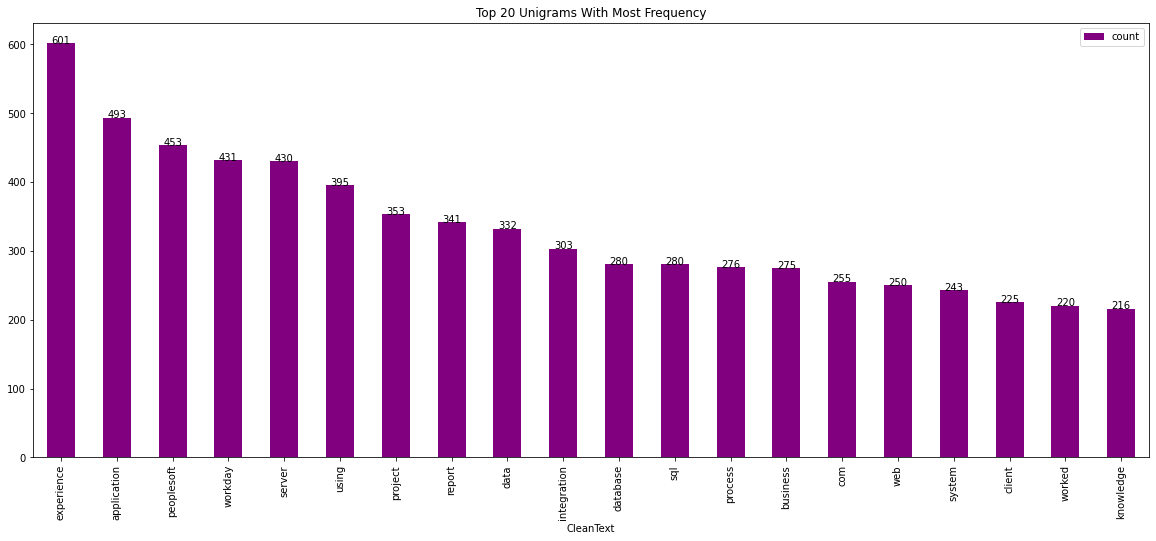

In [25]:
#get_top_n_words() returns the n-grams. n can be specified by user
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['Clean Text'], 20)  #Will Take  n = 20
#for word, freq in common_words:
    #print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['CleanText' , 'count'])
##Visualizing results
#Barchart for top 10 nouns + verbs
df1[0:20].plot.bar(x='CleanText', figsize=(20,8), title='Top 20 Unigrams With Most Frequency',color ='purple')
def addlabels(x,y):
  for i in range(len(x)):
    plt.text(i,y[i],y[i],ha = 'center')
addlabels(df1['CleanText'],df1['count'])
plt.show()

Inference: This plot demonstrates top unigrams or single most frequent words in the book.Since the resumes are related to technical skills, this plot lines perfectly with that. Words like "data", "sql", "reports" are used very often

##### The Distribution of Top Bigrams.


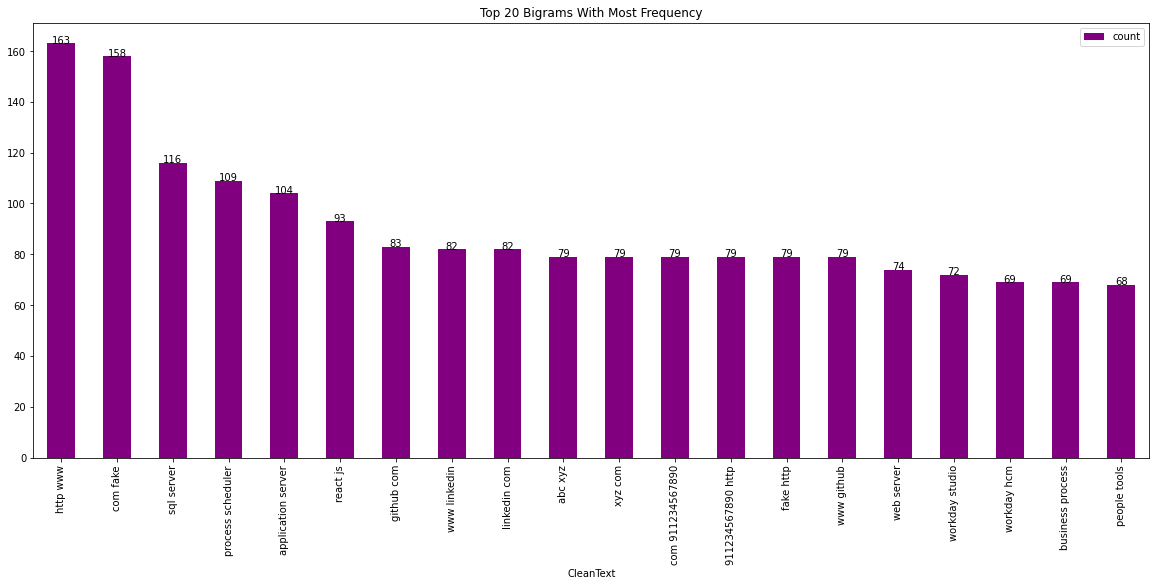

In [26]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['Clean Text'], 20)
#for word, freq in common_words:
    #print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['CleanText' , 'count'])
##Visualizing results
#Barchart for top 10 nouns + verbs
df2[0:20].plot.bar(x='CleanText', figsize=(20,8), title='Top 20 Bigrams With Most Frequency',color ='purple')
#Adding Labels
addlabels(df2['CleanText'],df2['count'])
plt.show()

Inference:
Words like "sql server", "http www", "abc xyz" are used together very often.This plot demonstrates the frequent use of bigrams

##### The Distribution of Top Trigrams


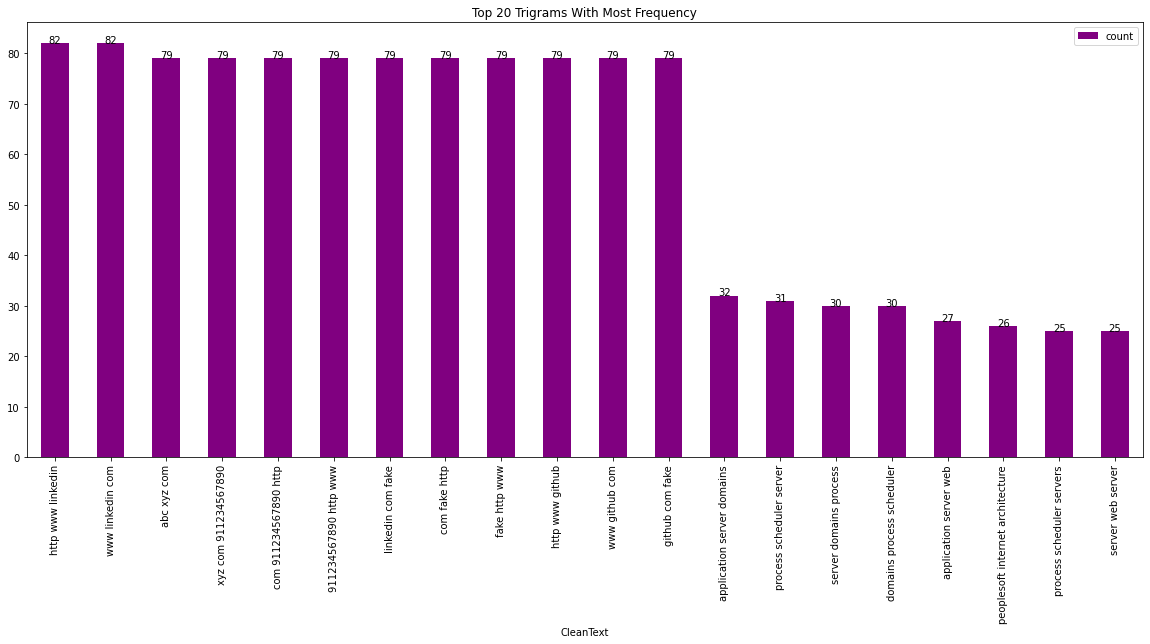

In [27]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['Clean Text'], 20)
#for word, freq in common_words:
    #print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['CleanText' , 'count'])
##Visualizing results
#Barchart for top 10 nouns + verbs
df3[0:20].plot.bar(x='CleanText', figsize=(20,8), title='Top 20 Trigrams With Most Frequency',color ='purple')
#Adding Labels
addlabels(df3['CleanText'],df3['count'])
plt.show()

Inference: Here We can See the Top 20 Trigrams of Corpus

##### Parts of Speech

In [28]:
#From nltk downloading pos 
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

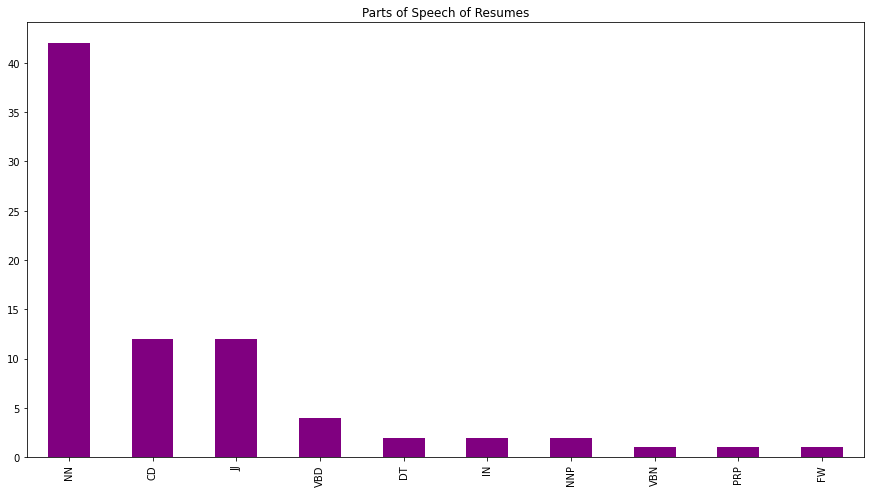

In [29]:
#Creating a Bar Graph To See Distribution of POS in Resumes
blob = TextBlob(str(df['Clean Text']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
#Getting POS with greater then 20 Frequency
pos_df = pos_df.pos.value_counts()[:20]
pos_df.plot.bar(x='pos', figsize=(15,8), title='Parts of Speech of Resumes',color = 'purple')
plt.show()

Inference: This plot represents the frequency of occurance of part-of-speech in the resumes.Proper nouns and nouns are used most often in the resumes followed by adjectives <br>
labels are: 
1. 'NN': 'Noun'
2. 'CD': 'numeral, cardinal'
3. 'JJ': 'adjective or numeral ordinal'
4. 'VBD':	'Verb, past tense'
5. 'DT': 'determiner'
6. 'IN': 'preposition or conjunction, subordinating'
7. 'NNP': 'Proper Noun, plural'
8. 'VBN': 'Verb, past participle'
9. 'PRP':	'Personal pronoun'
10. 'FW': 'Foreign Word'



##### Saving the DF as csv for Feature Extraction

In [ ]:
df.to_csv('Resume_df.csv')